In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [7]:
dataset_path = 'creditcard_2023.csv'

# Load data into a DataFrame
credit_card_df = pd.read_csv(dataset_path)

# Extract features (X) and labels (y)
X = credit_card_df.drop('id',axis=1)
X = X.drop('Class',axis=1).to_numpy()
y = credit_card_df['Class'].to_numpy()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (398041, 29)
The shape of X_val is: (85294, 29)
The shape of y_val is:  (85294,)


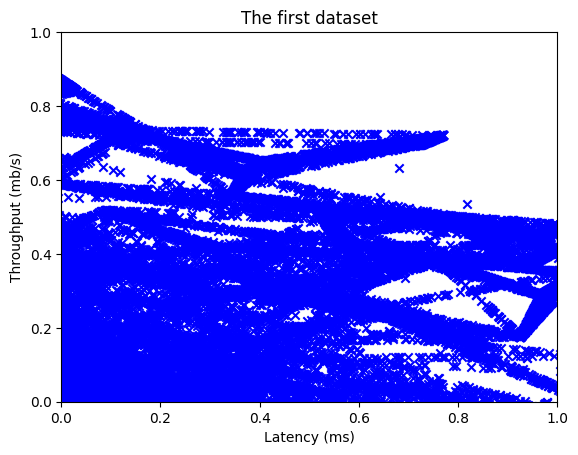

In [10]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b') 

# Set the title
plt.title("The first dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')
# Set axis range
plt.axis([0, 1, 0, 1])
plt.show()

In [16]:
def estimate_gaussian(X): 
    m, n = X.shape
    mu = np.sum(X,axis = 0)/m
    var = np.sum((X - mu)**2, axis = 0)/m
    return mu, var
    

In [17]:
mu, var = estimate_gaussian(X_train)              

print("Mean of each feature:", mu)
print("Variance of each feature:", var)


Mean of each feature: [ 7.67815901e-04 -1.42468415e-03  1.00599243e-03 -1.62659479e-03
  5.36121937e-04  1.55211006e-03  1.56977687e-03 -5.50142280e-04
  3.76763589e-04  1.01702555e-03 -1.36863525e-03  1.17625803e-04
  3.51003444e-04 -3.79468425e-05  9.83433604e-04 -7.83152347e-06
  2.33264423e-04  6.20406989e-04  1.33948361e-04 -1.18574782e-03
  1.91806741e-03 -1.07141170e-03  1.46572336e-03 -3.97168324e-04
 -1.65503995e-04  8.30588403e-04  6.47335049e-04  2.88838474e-04
  1.20453385e+04]
Variance of each feature: [9.98399279e-01 9.98222981e-01 9.98037321e-01 1.00129178e+00
 9.99533888e-01 1.00197362e+00 1.03071941e+00 9.99175096e-01
 9.98333403e-01 9.98612791e-01 1.00090736e+00 9.98209850e-01
 9.99411821e-01 9.99009577e-01 9.98713936e-01 1.00012876e+00
 9.97662404e-01 9.99069575e-01 1.00026986e+00 1.00102541e+00
 1.00062614e+00 9.98793700e-01 9.95721309e-01 9.99136468e-01
 9.95646869e-01 9.99680957e-01 1.00638606e+00 1.00049326e+00
 4.79174085e+07]


In [20]:

def multivariate_gaussian(X, mu, var):
    """
    Computes the probability 
    density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and var. If var is a matrix, it is
    treated as the covariance matrix. If var is a vector, it is treated
    as the var values of the variances in each dimension (a diagonal
    covariance matrix
    """
    
    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p
def visualize_fit(X, mu, var):
    """
    This visualization shows you the 
    probability density function of the Gaussian distribution. Each example
    has a location (x1, x2) that depends on its feature values.
    """
    
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx')


In [25]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        predictions = (p_val < epsilon)
        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))
        prec =  tp/ (tp + fp)
        rec = tp/(tp + fn)
        F1 = (2 *prec*rec)/(prec+rec)
        


    if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [26]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

C:\Users\USER\AppData\Local\Temp\ipykernel_14384\860061787.py:28: RuntimeWarning: invalid value encountered in scalar divide
  prec =  tp/ (tp + fp)


Best epsilon found using cross-validation: 1.092025e-16
Best F1 on Cross Validation Set: 0.666260


In [29]:
# Find the outliers in the training set 
outliers = p < epsilon

print('# Anomalies found: %d'% sum(p_val < epsilon))

# Anomalies found: 85293
